#### Analysis to determine feat importance from 1 to 30 days 
Roll analysis out for each time period to check importance over time 

Library 
- https://medium.com/@hsahu/stock-prediction-with-xgboost-a-technical-indicators-approach-5f7e5940e9e3
- https://hub.packtpub.com/cross-validation-strategies-for-time-series-forecasting-tutorial/
- http://www.zhengwenjie.net/tscv/
- https://github.com/TannerGilbert/Tutorials/tree/master/A%20guide%20to%20Ensemble%C2%A0Learning

#### Notes
 - Momentum Features Appear to provide the highest vale for short predictions
 - Macro features become more impportant as you approach 30 days

In [4]:


import sys, time, datetime
import streamlit as st
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objs as go
import numpy as np
import pandas as pd
import pylab as pl
import seaborn as sns
import sklearn as sk
from sklearn.ensemble import RandomForestClassifier, AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score, KFold, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve, roc_auc_score, mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.preprocessing import PolynomialFeatures, scale, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn import metrics, linear_model
from sklearn import preprocessing
from statsmodels.tsa.arima_model import ARIMA
from sklearn.tree import DecisionTreeRegressor
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

DEBUG = True

# Forecast timeperiod
days_ahead = [10]

# Input file date ranges
date_start = datetime.date(2012, 8, 1)
date_end = datetime.date(2020, 7, 30)

# Read File
file_buffer = "./Economic_Data_2020_08_01.xlsx"
session_state = pd.read_excel(file_buffer)

# Set time period for analysis 
session_state['Dates'] = pd.to_datetime(session_state['Dates']).dt.date
session_state= session_state[(session_state['Dates'] >= date_start) & 
                         (session_state['Dates'] <= date_end)]
csv_data = session_state.copy()
session_state = None

# Split parameters
split_perc = 0.20
random_flag = False

# Model Tuning 
_n_estimators = 30
_learning_rate = 0.50
_random = 1

#..........................................................................
#                           Pre-Processing            
#..........................................................................

if(DEBUG): print("Preprocessing data...\n")

csv_data['EARN_DOWN'] = csv_data['EARN_DOWN'].astype(np.float16)

csv_data['EARN_UP'] = csv_data['EARN_DOWN'].astype(np.float16)

csv_data['CDX_HY_momentum'] = \
                    csv_data['CDX_HY'] .rolling(window=10).mean() -  \
                    csv_data['CDX_HY'] .rolling(window=30).mean() /  \
                    csv_data['CDX_HY'] .rolling(window=30).mean()

csv_data['CDX_IG_momentum'] = \
                    csv_data['CDX_IG'] .rolling(window=10).mean() -  \
                    csv_data['CDX_IG'] .rolling(window=30).mean() /  \
                    csv_data['CDX_IG'] .rolling(window=30).mean()

csv_data['INDEX_IG_momentum'] = \
                    csv_data['LUACTRUU_Index_OAS'] .rolling(window=10).mean() -  \
                    csv_data['LUACTRUU_Index_OAS'] .rolling(window=30).mean() /  \
                    csv_data['LUACTRUU_Index_OAS'] .rolling(window=30).mean()

csv_data['INDEX_HY_momentum'] = \
                    csv_data['LF98TRUU_Index_OAS'] .rolling(window=10).mean() -  \
                    csv_data['LF98TRUU_Index_OAS'] .rolling(window=30).mean() /  \
                    csv_data['LF98TRUU_Index_OAS'] .rolling(window=30).mean()

csv_data['GOLD_momentum'] =  \
                    csv_data['GOLD'] .rolling(window=10).mean() -  \
                    csv_data['GOLD'] .rolling(window=30).mean() /  \
                    csv_data['GOLD'] .rolling(window=30).mean()


# For Each look ahead period 
for dh in days_ahead:
    # Create columns to track index changes over forecasting period 
    if(DEBUG): print("Adding {} Day Ahead".format(dh))
    
    # Test if target is higher or lower in days ahead (dh)
    IG_forecast_name = 'Index_IG_{}_Days_Ahead'.format(dh)
    csv_data[IG_forecast_name] = csv_data['LUACTRUU_Index_OAS'].shift(dh)
    
    HY_forecast_name = 'Index_HY_{}_Days_Ahead'.format(dh)
    csv_data[HY_forecast_name] = csv_data['LF98TRUU_Index_OAS'].shift(dh)

# Hold orginal data set 
complete_data = csv_data.dropna().copy()
csv_data = None

# Remove Target data from features
X = complete_data.drop([IG_forecast_name, HY_forecast_name, 'Dates'], axis=1)
feature_cols = X.columns
X = scale(X)

Y_HY = complete_data[HY_forecast_name]
Y_IG = complete_data[IG_forecast_name]

if(DEBUG): print("Splitting Test and Training Data...")
X_HY_train, X_HY_test, Y_HY_train, Y_HY_test = \
   train_test_split(X, Y_HY, test_size=split_perc, shuffle=random_flag)

X_IG_train, X_IG_test, Y_IG_train, Y_IG_test = \
   train_test_split(X, Y_IG, test_size=split_perc, shuffle=random_flag)

# Encode Target
if(DEBUG): print("Encoding target training and test data...")
lab_enc = preprocessing.LabelEncoder()
Y_HY_encoded = lab_enc.fit_transform(Y_HY)
Y_IG_encoded = lab_enc.fit_transform(Y_IG)

Y_HY_train_encoded = lab_enc.fit_transform(Y_HY_train)
Y_IG_train_encoded = lab_enc.fit_transform(Y_IG_train)

Y_HY_test_encoded = lab_enc.fit_transform(Y_HY_test)
Y_IG_test_encoded = lab_enc.fit_transform(Y_IG_test)

print('Done!')

Preprocessing data...

Adding 10 Day Ahead
Splitting Test and Training Data...
Encoding target training and test data...
Done!


Mean cross-validataion score: 0.53
Accuracy: 0.53 (+/- 0.417)


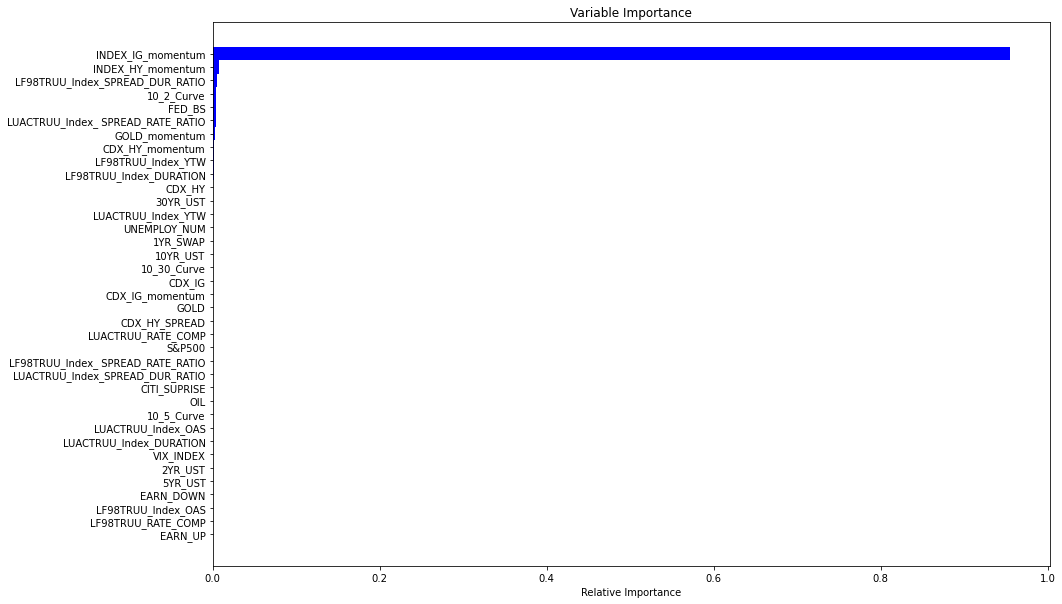

In [5]:
model = XGBRegressor()
model.fit(X_IG_train,Y_IG_train)

# Predict
y_2 = model.predict(X_IG_test)
tss = TimeSeriesSplit(n_splits=5).split(X)
scores = cross_val_score(model, X, Y_IG, cv=tss)
print("Mean cross-validataion score: %.2f" % scores.mean())
print("Accuracy: %0.2f (+/- %0.3f)" % (scores.mean(), scores.std()))
def feature_importance():
    #importances = regr_2.best_estimator_.feature_importances_
    importances = model.feature_importances_
    feats = {} 
    for feature, importance in zip(feature_cols, importances):
        feats[feature] = importance 

    feats = sorted(feats.items(), key=lambda x: x[1],  reverse=False) 
    feats = dict(feats)

    width = 1
    keys = feats.keys()
    values = feats.values()
    plt.figure(figsize=(15, 10)) 
    pl.barh(range(len(feats)), values, width, align='center', color="blue")
    plt.yticks(range(len(feats)), ["{}".format(v) for v in feats.keys()])

    pl.title("Variable Importance")
    pl.xlabel("Relative Importance")
feature_importance()

Done
